# Homework 4

### Due: Wed Dec. 6 @ 9pm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed(123)

## Use PCA to plot the digits dataset

The digits dataset is composed of a set of images of handwritten digits 0 to 9.
There are 1797 images, each 32x32 pixels.
If we flatten out each image we get a dataset of 1797 observations, each with 64 features, each belonging to one of 10 classes.
We can't plot them in 64 dimensional space, so we will use PCA to reduce the dimensionality to 2.
Hopefully the data will still be clustered by class.

In [2]:
# first we'll load the data
from sklearn.datasets import load_digits
digits = load_digits()
X = digits['data']
X.shape

(1797, 64)

In [3]:
# using PCA from sklearn.decomposition
from sklearn.decomposition import PCA

In [4]:
# create a pca object that will result in 2 components being returned
pca = PCA(n_components=2)

In [5]:
# do a fit_transform on the digits data to get our new X
# the resulting shape of the new X should be (1797,2)
X_2d = pca.fit_transform(X)

In [6]:
# grab the labels from the digits dataset
y = digits['target']

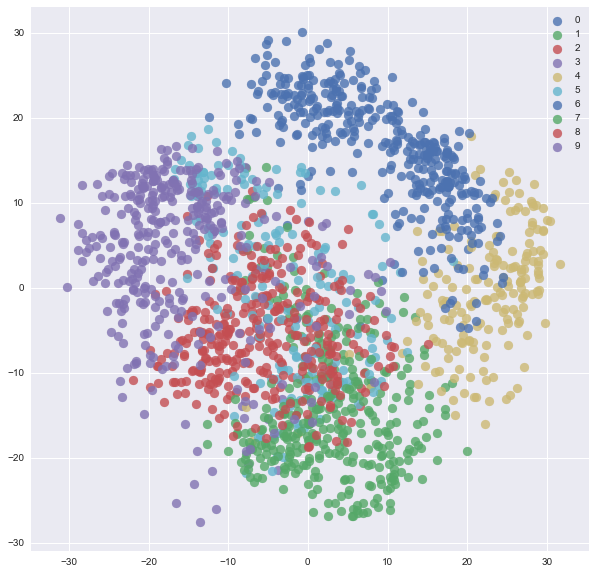

In [7]:
# for each label, create a scatter plot on the same figure
# we should see that 0 and 1 are far apart, as well as 3 and 4
fig = plt.figure(figsize=(10,10))
for i in range(10):
    X_digit = X_2d[y==i]
    _ = plt.scatter(X_digit[:,0],X_digit[:,1],s=80,alpha=0.8)
_ = plt.legend(range(10))

## K-Means Clustering

Imaging we were given the image data without their targets. We can use k-means clustering to see if there are any obvious clusters in the full 64 dimensional space, and then plot the resulting cluster assignments in our 2D representation.

In [8]:
# using KMeans from sklearn.cluster
from sklearn.cluster import KMeans

In [9]:
# create a KMeans object which will generate 10 clusters
km = KMeans(n_clusters=10)

In [10]:
# use fit_predict() to both fit our k-means model and generate cluster predictions 
# on our full X dataset with 64 features
# note: cluster assignment values will be from 0 to 9
cluster_assignments = km.fit_predict(X)
cluster_assignments

array([1, 7, 7, ..., 7, 0, 0])

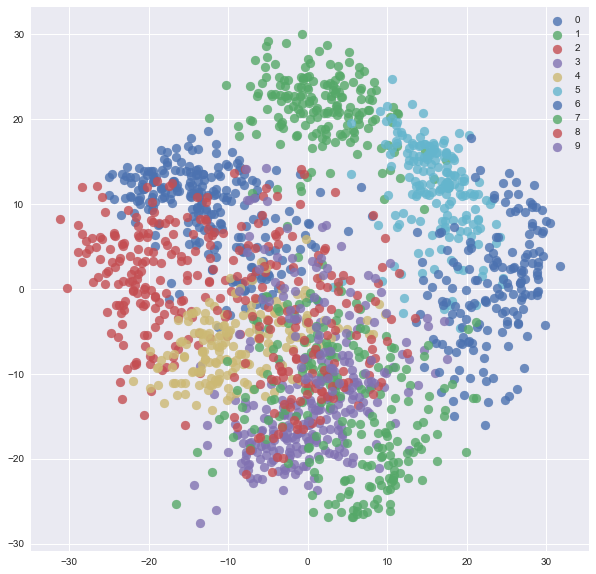

In [11]:
# create the same plot as we did above, again using the X_2d data
# but this time one plot per cluster
# note that the cluster assignments should look very similar, 
#   meaning that the data is highly clustered in its original space even though it overlaps in 2d
# also note that the colors may be different from the plot above, since there is no ordering to the clusters
fig = plt.figure(figsize=(10,10))
for i in range(10):
    cluster = X_2d[cluster_assignments==i]
    _ = plt.scatter(cluster[:,0],cluster[:,1],s=80,alpha=0.8)
_ = plt.legend(range(10))

## Hypothesis Testing with an A/B test

Suppose we work at a large company that is developing online data science tools. Currently the tool has interface type A but we'd like to know if using interface tool B might be more efficient.
To measure this, we'll look at length of active work on a project (aka project length).
We'll perform an A/B test where half of the projects will use interface A and half will use interface B.

In [12]:
# read in project lengths from '../data/project_lengths'
# there should be 1000 observations for both interfaces
df = pd.read_csv('../data/project_lengths.csv')
df.describe()

,lengths_A,lengths_B
count,1000.000000,1000.000000
mean,13.851284,12.269331
std,17.470609,17.518489
min,0.281379,0.182712
25%,4.270191,3.745311
50%,8.565148,7.149699
75%,16.480841,14.321771
max,202.925185,316.342642


In [13]:
# calculate the difference in mean project length between interface A and B
# for consistency, subtracting A from B
# hint: this number should be negative here (could interpret as faster)
mean_A = df['lengths_A'].mean()
mean_B = df['lengths_B'].mean()
observed_mean_diff = mean_B - mean_A
observed_mean_diff

-1.5819526645396227

In [14]:
# we'll perform a permutation test to see how significant this result is
# generate 10000 random permutation samples of mean difference
# hint: use np.random.permutation
perm_mean_diffs = []
n_samples = 10000
combined_times = np.concatenate([df.lengths_A.values, df.lengths_B.values])
n_A = 1000
for i in range(n_samples):
    rand_perm = np.random.permutation(combined_times)
    rand_mean_A = np.mean(rand_perm[:n_A])
    rand_mean_B = np.mean(rand_perm[n_A:])
    perm_mean_diffs.append(rand_mean_B-rand_mean_A)

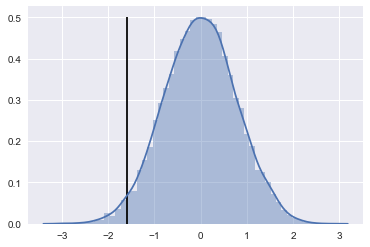

In [15]:
# use seaborn to plot the distribution of mean differences
# use plt.vlines to plot a line at our observed difference in means
_ = sns.distplot(perm_mean_diffs)
_ = plt.vlines(observed_mean_diff,0,0.5)

In [16]:
# the plot should seem to indicate significance, but let's calculate a one-tailed p_value
p_value = sum(np.array( perm_mean_diffs) <= observed_mean_diff) / len( perm_mean_diffs)
p_value

0.022800000000000001

In [17]:
# is this significant at an alpha level of 0.05?
# hint: it should be
alpha_level = 0.05
p_value < alpha_level

True

In [18]:
# we can calculate the effect size of our observation
observed_effect_size = np.abs(observed_mean_diff) / (np.std(combined_times))
observed_effect_size

0.090378203960904513

In [19]:
# we'll use this for the next 2 steps
from statsmodels.stats.power import tt_ind_solve_power

In [20]:
# what is the power of our current experiment?
# e.g. how likely is it that correctly decided that B is better than A 
#   given the observed effect size, number of observations and alpha level we used above
# since these are independent samples we can use tt_ind_solve_power
# hint: the power we get should not be good
power = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = n_A,         # the number of observations in A
                           alpha = alpha_level, # our alpha level
                           power = None,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
power

0.52394974391671145

In [21]:
# how many observations for each of A and B would we need to get a power of .9
#   for our observed effect size and alpha level
# eg. having a 90% change of correctly deciding B is better than A
n_obs_A = tt_ind_solve_power(effect_size = observed_effect_size,
                             nobs1 = None,
                             alpha = alpha_level,
                             power = 0.9,
                             ratio = 1
                            )
n_obs_A

2573.717112044275